In [5]:
# Setup the environment first

# read: https://github.com/mirnylab/cooler/issues/138 for more details:

# !export MKL_NUM_THREADS=1 - # not working in a notebook ((
# instead do this, after making sure mkl is installed
import mkl
mkl.set_num_threads(1)

In [6]:
# neccessary modules to be imported

import os.path as op
from scipy.stats import poisson
import pandas as pd
import numpy as np
import cooler

from cooltools import dotfinder

%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker

from cooltools.lib import numutils

In [7]:

# keeping some of the relevant CLI commands here
# useful for preprocessing cooler files - before calling dots

# 1. re-balancing - cis-only is worth checking out at the very least ...
# cooler balance -p {threads} --ignore-diags 1 --force --name 'wsnake' {input}::/resolutions/{res}

# 2. calculation of expected
# cooltools compute-expected -p {threads} --weight-name 'wsnake' --drop-diags 1 {input[0]}::/resolutions/{res}

In [30]:

# the control - normal human cells - parental cells line (perfect ctrl)
ctr = cooler.Cooler("/home/venevs/Cancer/Ctrl_1Mb.mcool::/resolutions/1000000")

# 11 - transloc 4o and 8q; 2p - 20q
sam11 = cooler.Cooler("/home/venevs/Cancer/Sample11_4p-8q_2p-20q.1Mb.mcool::/resolutions/1000000")

# 6a - transloc 4 and 6; 5 and X and maybe isochrom - 2p
sam6a = cooler.Cooler("/home/venevs/Cancer/Sample6a_iso2p_4-6_5-X.1Mb.mcool::/resolutions/1000000")

# 6b - transloc 4 and 6 and maybe isochrom - 2p
sam6b = cooler.Cooler("/home/venevs/Cancer/Sample6b_iso2p_4-6.1Mb.mcool::/resolutions/1000000")


# ! cooler zoomify -r 1000000,2000000,3000000,4000000,5000000,8000000,10000000 --balance -o /home/venevs/Cancer/Ctrl_1Mb.mcool /home/venevs/Cancer/Ctrl_1Mb.cool
# ! cooler zoomify -r 1000000,2000000,3000000,4000000,5000000,8000000,10000000 --balance -o /home/venevs/Cancer/Sample11_4p-8q_2p-20q.1Mb.mcool /home/venevs/Cancer/Sample11_4p-8q_2p-20q.1Mb.cool
# ! cooler zoomify -r 1000000,2000000,3000000,4000000,5000000,8000000,10000000 --balance -o /home/venevs/Cancer/Sample6a_iso2p_4-6_5-X.1Mb.mcool /home/venevs/Cancer/Sample6a_iso2p_4-6_5-X.1Mb.cool
# ! cooler zoomify -r 1000000,2000000,3000000,4000000,5000000,8000000,10000000 --balance -o /home/venevs/Cancer/Sample6b_iso2p_4-6.1Mb.mcool /home/venevs/Cancer/Sample6b_iso2p_4-6.1Mb.cool

# in this example chromosomes 4 and 8  and also 2 and 20 undergo arm-level rearrangements ...

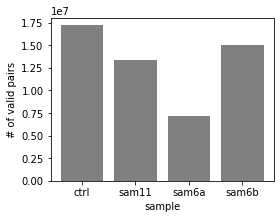

In [9]:
fff = [ctr.info["sum"],
sam11.info["sum"],
sam6a.info["sum"],
sam6b.info["sum"]]
nnn = ["ctrl","sam11","sam6a","sam6b"]

plt.bar(range(len(fff)),fff,color='gray')
ax = plt.gca()
ax.set_xticks(range(len(fff)))
ax.set_xticklabels(nnn)
ax.set_ylabel("# of valid pairs")
ax.set_xlabel("sample")
fig = plt.gcf()
fig.set_size_inches(4,3)
# ax.set_yscale('log')

### higlass - for fun only - skip if not needed

In [ ]:
from higlass.client import View, Track
from higlass.tilesets import cooler
import higlass

ts1 = cooler('/home/venevs/Cancer/Ctrl_1Mb.mcool')
ts2 = cooler('/home/venevs/Cancer/Sample11_4p-8q_2p-20q.1Mb.mcool')
ts3 = cooler("/home/venevs/Cancer/Sample6a_iso2p_4-6_5-X.1Mb.mcool")
ts4 = cooler("/home/venevs/Cancer/Sample6b_iso2p_4-6.1Mb.mcool")

# port has to be different from the one notebook is running on:
glass_port = 9090

# somehow server vs file_url makes a difference, when doing this ...
tr1 = Track('heatmap', tileset=ts1,server=f"http://vangogh.ad.umassmed.edu:{glass_port}/api/v1",height=340)
tr2 = Track('heatmap', tileset=ts2,server=f"http://vangogh.ad.umassmed.edu:{glass_port}/api/v1",height=340)
tr3 = Track('heatmap', tileset=ts3,server=f"http://vangogh.ad.umassmed.edu:{glass_port}/api/v1",height=340)
tr4 = Track('heatmap', tileset=ts4,server=f"http://vangogh.ad.umassmed.edu:{glass_port}/api/v1",height=340)

view1 = View([tr1],x=0,y=0,width=6,height=24)
view2 = View([tr2],x=6,y=0,width=6,height=24)
view3 = View([tr3],x=0,y=12,width=6,height=24)
view4 = View([tr4],x=6,y=12,width=6,height=24)
display, server, viewconf = higlass.display([view1,view2,view3,view4],host="0.0.0.0",server_port=glass_port)

display


In [1]:
#! cooltools compute-expected -t cis --no-balance /home/venevs/Cancer/Sample6a_iso2p_4-6_5-X.1Mb.cool
! cooltools compute-expected -t trans -o "ctrl.trans.exp" --no-balance /home/venevs/Cancer/Ctrl_1Mb.mcool::/resolutions/1000000
! cooltools compute-expected -t trans -o "sam6a.trans.exp" --no-balance /home/venevs/Cancer/Sample6a_iso2p_4-6_5-X.1Mb.mcool::/resolutions/1000000

In [10]:
from cooltools import coverage

In [39]:
 # this is just a little helper function to
# get a "balanced" coverage, from a cooler
# a an arbitrary weight column ...

def get_rebalanced_cov(clr,weights):
    mat = clr.matrix(balance=False)[:]
    # fill diags with zeros - otherwise balancing is not good
    mat = numutils.fill_diag(mat, 0, i=0)
    mat = numutils.fill_diag(mat, 0, i=1)
    mat = numutils.fill_diag(mat, 0, i=-1)
    #
    return np.nansum(
            mat*np.outer(weights,weights),
            axis=0
        )



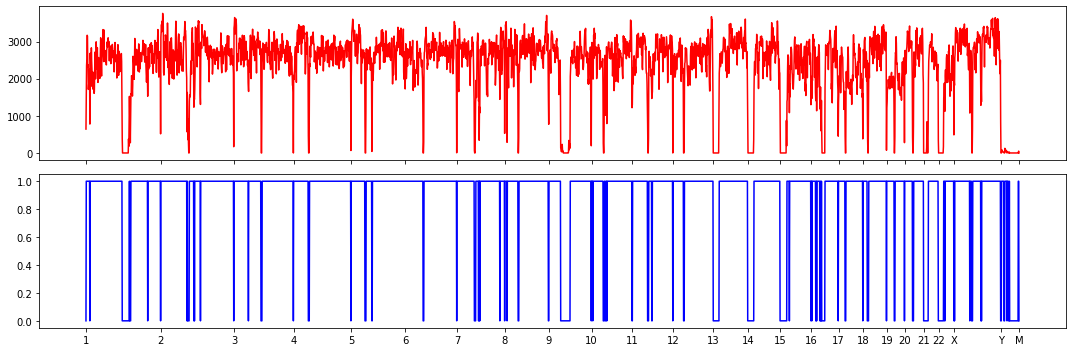

In [44]:
cov = coverage.get_coverage(ctr,ignore_diags=1)

# "balanced" coverage ...
ctr_w = ctr.bins()["weight"][:]
cov_bal = get_rebalanced_cov(ctr,ctr_w)


f,(axup,axbot) = plt.subplots(nrows=2,sharex=True,tight_layout=True)

axup.plot(cov[1],'r-')
axbot.plot(cov_bal,'b-')
# fig = plt.gcf()
# ax = plt.gca()

f.set_size_inches(15,5)

_ = axup.set_xticks(ctr.bins()[:].groupby("chrom")["start"].idxmin().values)
_ = axup.set_xticklabels(ctr.chromnames)
_ = axbot.set_xticks(ctr.bins()[:].groupby("chrom")["start"].idxmin().values)
_ = axbot.set_xticklabels(ctr.chromnames)

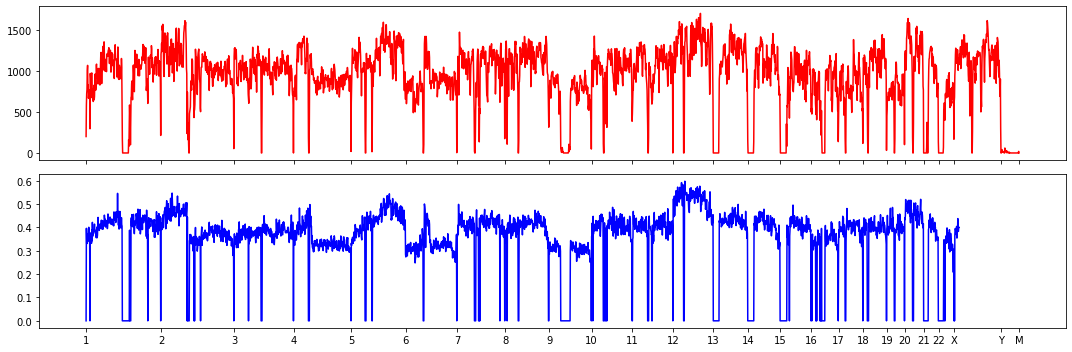

In [48]:
cov = coverage.get_coverage(sam6a,ignore_diags=1)

# "balanced" coverage using control's coverage ...
ctr_w = ctr.bins()["weight"][:]
cov_bal = get_rebalanced_cov(sam6a,ctr_w)

f,(axup,axbot) = plt.subplots(nrows=2,sharex=True,tight_layout=True)

# exclude chrY etc ...
exclude_bins = 200

axup.plot(cov[1],'r-')
axbot.plot(cov_bal[:-exclude_bins],'b-')

f.set_size_inches(15,5)

_ = axbot.set_xticks(sam6a.bins()[:].groupby("chrom")["start"].idxmin().values)
_ = axbot.set_xticklabels(sam6a.chromnames)
_ = axup.set_xticks(sam6a.bins()[:].groupby("chrom")["start"].idxmin().values)
_ = axup.set_xticklabels(sam6a.chromnames)

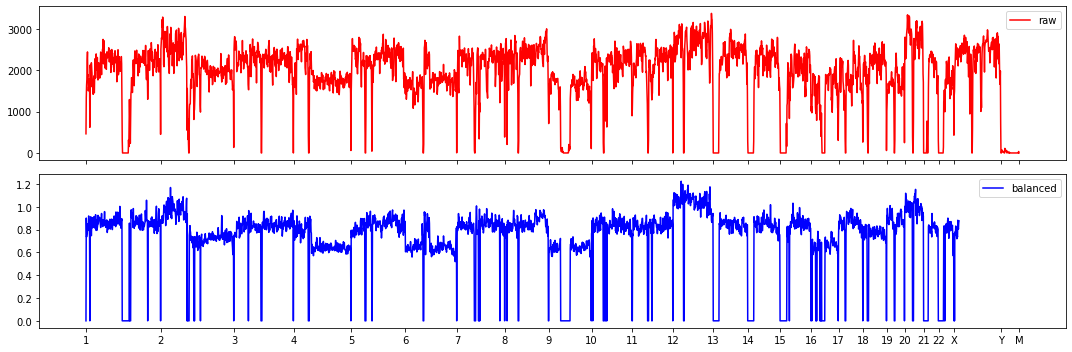

In [52]:
cov = coverage.get_coverage(sam6b,ignore_diags=1)

# "balanced" coverage using control's coverage ...
ctr_w = ctr.bins()["weight"][:]
cov_bal = get_rebalanced_cov(sam6b,ctr_w)

f,(axup,axbot) = plt.subplots(nrows=2,sharex=True,tight_layout=True)

# exclude chrY etc ...
exclude_bins = 200

axup.plot(cov[1],'r-',label="raw")
axbot.plot(cov_bal[:-exclude_bins],'b-',label="balanced")
axbot.legend()
axup.legend()

f.set_size_inches(15,5)

_ = axbot.set_xticks(sam6b.bins()[:].groupby("chrom")["start"].idxmin().values)
_ = axbot.set_xticklabels(sam6a.chromnames)
_ = axup.set_xticks(sam6b.bins()[:].groupby("chrom")["start"].idxmin().values)
_ = axup.set_xticklabels(sam6a.chromnames)

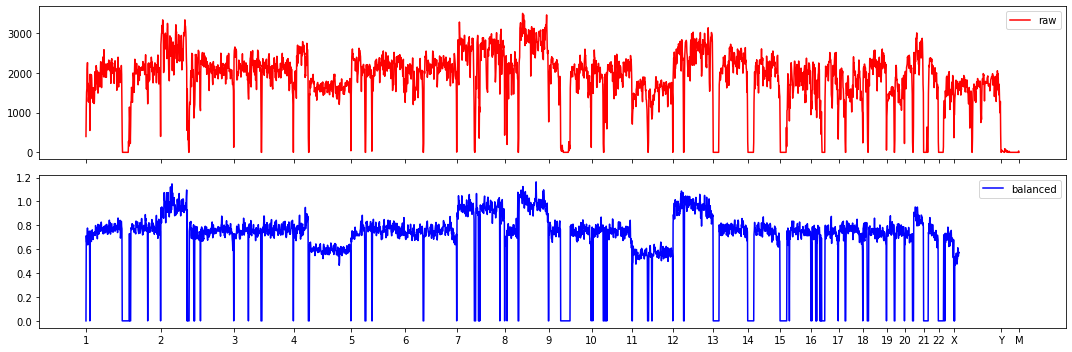

In [53]:
cov = coverage.get_coverage(sam11,ignore_diags=1)



# "balanced" coverage using control's coverage ...
ctr_w = ctr.bins()["weight"][:]
cov_bal = get_rebalanced_cov(sam11,ctr_w)

f,(axup,axbot) = plt.subplots(nrows=2,sharex=True,tight_layout=True)

# exclude chrY etc ...
exclude_bins = 200

axup.plot(cov[1],'r-',label="raw")
axbot.plot(cov_bal[:-exclude_bins],'b-',label="balanced")
axbot.legend()
axup.legend()

f.set_size_inches(15,5)

_ = axbot.set_xticks(sam11.bins()[:].groupby("chrom")["start"].idxmin().values)
_ = axbot.set_xticklabels(sam6a.chromnames)
_ = axup.set_xticks(sam11.bins()[:].groupby("chrom")["start"].idxmin().values)
_ = axup.set_xticklabels(sam6a.chromnames)


In [54]:
sam6a_trans_exp = pd.read_csv("sam6a.trans.exp",sep='\t')
ctrl_trans_exp = pd.read_csv("ctrl.trans.exp",sep='\t')

/home/venevs/miniconda3/envs/cooler-env/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


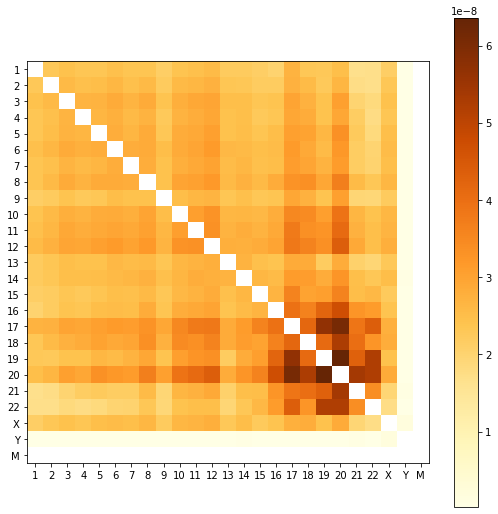

In [34]:
trans_mat = pd.pivot(data = ctrl_trans_exp,
         index="chrom1",
         columns="chrom2",
         values = "count.avg")

trans_mat = trans_mat.loc[sam6a.chromnames,sam6a.chromnames]



for i in range(len(sam6a.chromnames)):
    for j in range(i,len(sam6a.chromnames)):
        trans_mat.iloc[j,i] = trans_mat.iloc[i,j]
        
ctr_te = trans_mat/ctr.info['sum']
     
    
plt.imshow((ctr_te),cmap="YlOrBr")
ax = plt.gca()
fig = plt.gcf()

fig.set_size_inches(9,9)
_ = ax.set_xticks(range(len(sam6a.chromnames)))
_ = ax.set_xticklabels(sam6a.chromnames)

_ = ax.set_yticks(range(len(sam6a.chromnames)))
_ = ax.set_yticklabels(sam6a.chromnames)

plt.colorbar()

/home/venevs/miniconda3/envs/cooler-env/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


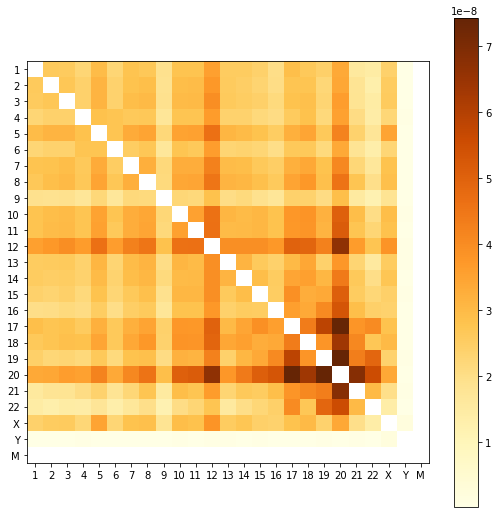

In [35]:
trans_mat = pd.pivot(data = sam6a_trans_exp,
         index="chrom1",
         columns="chrom2",
         values = "count.avg")

trans_mat = trans_mat.loc[sam6a.chromnames,sam6a.chromnames]



for i in range(len(sam6a.chromnames)):
    for j in range(i,len(sam6a.chromnames)):
        trans_mat.iloc[j,i] = trans_mat.iloc[i,j]
        
sam6a_te = trans_mat/sam6a.info['sum']

plt.imshow((trans_mat/sam6a.info['sum']),cmap="YlOrBr")
ax = plt.gca()
fig = plt.gcf()

fig.set_size_inches(9,9)
_ = ax.set_xticks(range(len(sam6a.chromnames)))
_ = ax.set_xticklabels(sam6a.chromnames)

_ = ax.set_yticks(range(len(sam6a.chromnames)))
_ = ax.set_yticklabels(sam6a.chromnames)

plt.colorbar()

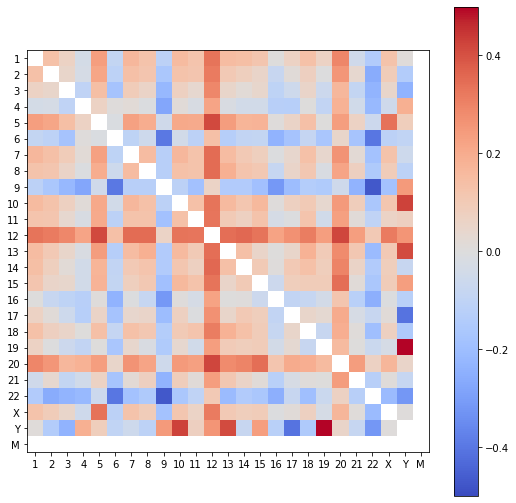

In [36]:

plt.imshow(np.log(sam6a_te/ctr_te),cmap="coolwarm",vmin=-0.5,vmax=0.5)#,vmin=0,vmax=2)
ax = plt.gca()
fig = plt.gcf()

fig.set_size_inches(9,9)
_ = ax.set_xticks(range(len(sam6a.chromnames)))
_ = ax.set_xticklabels(sam6a.chromnames)

_ = ax.set_yticks(range(len(sam6a.chromnames)))
_ = ax.set_yticklabels(sam6a.chromnames)

plt.colorbar()

In [55]:
# !cooler balance -p 6 --ignore-diags 2 --force /home/venevs/Cancer/Sample11_4p-8q_2p-20q.1Mb.cool
# !cooler balance -p 6 --ignore-diags 2 --force /home/venevs/Cancer/Ctrl_1Mb.cool
# !cooler balance -p 6 --ignore-diags 2 --force /home/venevs/Cancer/Sample6a_iso2p_4-6_5-X.1Mb.cool
# !cooler balance -p 6 --ignore-diags 2 --force /home/venevs/Cancer/Sample6b_iso2p_4-6.1Mb.cool

In [56]:
balanced = False
# no_balance = False

In [57]:
sam6a_mat = sam6a.matrix(balance=balanced).fetch("2")
ctr_mat = ctr.matrix(balance=balanced).fetch("2")
sam11_mat = sam11.matrix(balance=balanced).fetch("2")
sam6b_mat = sam6b.matrix(balance=balanced).fetch("2")

/home/venevs/miniconda3/envs/cooler-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/home/venevs/miniconda3/envs/cooler-env/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/home/venevs/miniconda3/envs/cooler-env/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/venevs/miniconda3/envs/cooler-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


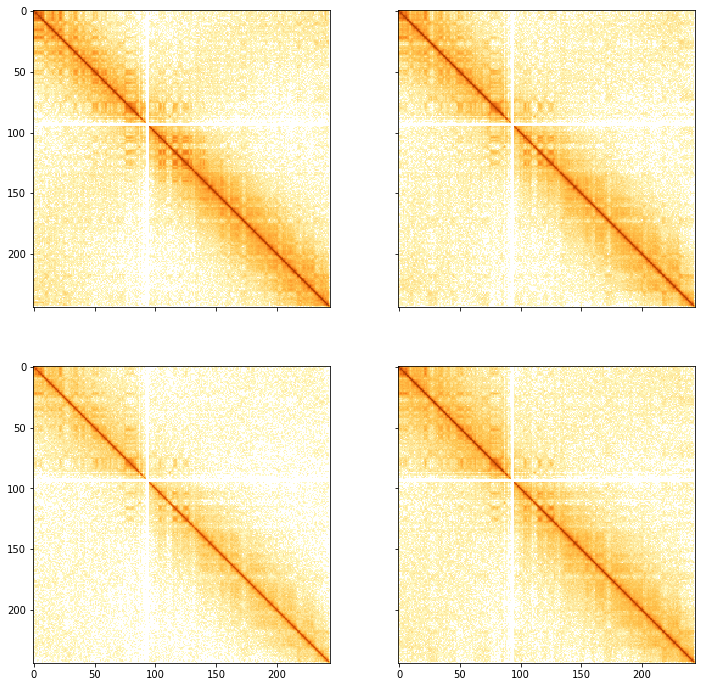

In [58]:
fig,axs = plt.subplots(nrows=2,ncols=2,sharex=True,sharey=True)

fig.set_size_inches(12,12)

params = {"vmin":-1,"vmax":10}

axs[0,0].imshow(np.log(ctr_mat),cmap='YlOrBr',**params)
axs[0,1].imshow(np.log(sam11_mat),cmap='YlOrBr',**params)

axs[1,0].imshow(np.log(sam6a_mat),cmap='YlOrBr',**params)
c = axs[1,1].imshow(np.log(sam6b_mat),cmap='YlOrBr',**params)

# plt.colorbar(c)

In [59]:
from bioframe.io import resources

In [66]:
centrs = resources.fetch_centromeres('hg19')
centrs = centrs.set_index("chrom")

AttributeError: module 'bioframe.io.resources' has no attribute 'fetch_centromeres'

In [61]:
from cooltools import expected


In [62]:
90500000/2000000

45.25

In [63]:
centrs.loc["chr2","start"]

NameError: name 'centrs' is not defined

In [64]:
expected.diagsum_asymm??

In [65]:
arms = [("2",0,centrs.loc["chr2","start"]),("2",centrs.loc["chr2","end"],ctr.chromsizes["2"])]

_1 = True
if _1:
    filed_name = "balanced"
    transforms = {filed_name: lambda pixels: pixels["count"]*pixels["weight1"]*pixels["weight2"]}
else:
    filed_name = "count"
    transforms = {}


def get_arm_exp(c,arms,norm=None,filed_name = "count"):
    arm_exp = expected.diagsum(c,supports=arms,transforms=transforms)
    p = arm_exp[arms[0]]
    q = arm_exp[arms[1]]
    p[filed_name+".avg"] = p[filed_name+".sum"]/p["n_valid"]
    q[filed_name+".avg"] = q[filed_name+".sum"]/q["n_valid"]
    if norm is not None:
        p[filed_name+".avg"] = p[filed_name+".avg"]/norm
        q[filed_name+".avg"] = q[filed_name+".avg"]/norm
    return p, q



def get_iarm_exp(c,arms,norm=None,filed_name = "count"):
    iarm_exp = expected.diagsum_asymm(c,supports1=[arms[0]],supports2=[arms[1]],transforms=transforms)
    pq = iarm_exp[arms[0],arms[1]]
    pq[filed_name+".avg"] = pq[filed_name+".sum"]/pq["n_valid"]
    if norm is not None:
        pq[filed_name+".avg"] = pq[filed_name+".avg"]/norm
    return pq

# iarm_exp = expected.diagsum_asymm(ctr,supports1=[arms[0]],supports2=[arms[1]],transforms=transforms)
# p = arm_exp[arms[0]]
# q = arm_exp[arms[1]]
# p[filed_name+".avg"] = p[filed_name+".sum"]/p["n_valid"]
# q[filed_name+".avg"] = q[filed_name+".sum"]/q["n_valid"]
# if norm is not None:
#     p[filed_name+".avg"] = p[filed_name+".avg"]/norm
#     q[filed_name+".avg"] = q[filed_name+".avg"]/norm
# return p, q



ctr_2p,ctr_2q = get_arm_exp(ctr,arms=arms,filed_name = filed_name)
sam11_2p,sam11_2q = get_arm_exp(sam11,arms=arms,filed_name = filed_name)
sam6a_2p,sam6a_2q = get_arm_exp(sam6a,arms=arms,filed_name = filed_name)
sam6b_2p,sam6b_2q = get_arm_exp(sam6b,arms=arms,filed_name = filed_name)


ctr_2pq = get_iarm_exp(ctr,arms=arms,filed_name = filed_name)
sam11_2pq = get_iarm_exp(sam11,arms=arms,filed_name = filed_name)
sam6a_2pq = get_iarm_exp(sam6a,arms=arms,filed_name = filed_name)
sam6b_2pq = get_iarm_exp(sam6b,arms=arms,filed_name = filed_name)

NameError: name 'centrs' is not defined

In [ ]:
arms = [("3",0,centrs.loc["chr3","start"]),("3",centrs.loc["chr3","end"],ctr.chromsizes["3"])]

# ctr_3p,ctr_3q = get_arm_exp(ctr,arms=arms,norm=ctr.info["sum"])
# sam11_3p,sam11_3q = get_arm_exp(sam11,arms=arms,norm=sam11.info["sum"])
# sam6a_3p,sam6a_3q = get_arm_exp(sam6a,arms=arms,norm=sam6a.info["sum"])
# sam6b_3p,sam6b_3q = get_arm_exp(sam6b,arms=arms,norm=sam6b.info["sum"])



ctr_3p,ctr_3q = get_arm_exp(ctr,arms=arms,filed_name = filed_name)
sam11_3p,sam11_3q = get_arm_exp(sam11,arms=arms,filed_name = filed_name)
sam6a_3p,sam6a_3q = get_arm_exp(sam6a,arms=arms,filed_name = filed_name)
sam6b_3p,sam6b_3q = get_arm_exp(sam6b,arms=arms,filed_name = filed_name)

In [ ]:
#plt.plot(exp_2p)

(0.99*ctr_2pq[filed_name+'.avg']).plot(label="ctr")
sam11_2pq[filed_name+'.avg'].plot(label="sam11")
(0.99*sam6a_2pq[filed_name+'.avg']).plot(label="sam6a")
sam6b_2pq[filed_name+'.avg'].plot(label="sam6b")



ax = plt.gca()
# ax.set_xscale('log')
ax.set_yscale('log')


ax.legend()

# exp_2q['count.avg'].plot()

In [ ]:
#plt.plot(exp_2p)

(0.8*ctr_2p[filed_name+'.avg']).plot(label="ctr")
sam11_2p[filed_name+'.avg'].plot(label="sam11")
(2*sam6a_2p[filed_name+'.avg']).plot(label="sam6a")
sam6b_2p[filed_name+'.avg'].plot(label="sam6b")



ax = plt.gca()
# ax.set_xscale('log')
ax.set_yscale('log')


ax.legend()

# exp_2q['count.avg'].plot()

In [ ]:

(0.8*ctr_3q[filed_name+'.avg']).plot(label="ctr")
sam11_3q[filed_name+'.avg'].plot(label="sam11")
(2*sam6a_3q[filed_name+'.avg']).plot(label="sam6a")
sam6b_3q[filed_name+'.avg'].plot(label="sam6b")



ax = plt.gca()
# ax.set_xscale('log')
ax.set_yscale('log')


ax.legend()

# exp_2q['count.avg'].plot()

In [ ]:

(0.8*ctr_2q[filed_name+'.avg']).plot(label="ctr")
sam11_2q[filed_name+'.avg'].plot(label="sam11")
(2*sam6a_2q[filed_name+'.avg']).plot(label="sam6a")
sam6b_2q[filed_name+'.avg'].plot(label="sam6b")



ax = plt.gca()
# ax.set_xscale('log')
ax.set_yscale('log')


ax.legend()


In [ ]:
c1 = ctr.matrix(balance=balanced).fetch("2")
c2 = ctr.matrix(balance=balanced).fetch("20")
c12 = ctr.matrix(balance=balanced).fetch("2","20")

c1_width = c1.shape[1]
c2_width = c2.shape[1]

c1_height = c1.shape[0]
c2_height = c2.shape[0]


width = c1_width+c2_width
height = c1_height+c2_height

cmonster = np.zeros((height,width))

In [ ]:
coe1 = get_OE(c1)
coe2 = get_OE(c2)

coe12 = c12/np.nanmean(c12)

cmonster[:c1_width,:c1_height] = coe1
cmonster[c1_width:,c1_height:] = coe2
cmonster[:c1_width,c1_height:] = coe12
cmonster[c1_height:,:c1_height] = coe12.transpose()

In [ ]:
m1 = mut.matrix(balance=balanced).fetch("2")
m2 = mut.matrix(balance=balanced).fetch("20")
m12 = mut.matrix(balance=balanced).fetch("2","20")
print(m1.shape)
print(m2.shape)
print(m12.shape)

m1_width = m1.shape[1]
m2_width = m2.shape[1]

m1_height = m1.shape[0]
m2_height = m2.shape[0]


width = m1_width+m2_width
height = m1_height+m2_height

monster = np.zeros((height,width))


In [ ]:
plt.imshow(np.log(m1),cmap='YlOrBr')

In [ ]:
plt.imshow(np.log(m2),cmap='YlOrBr')

In [ ]:
def get_OE(A,ignore_diags=2):
    A = np.array(A)
    A[~np.isfinite(A)] = 0
    mask = A.sum(axis=0) > 0

    if A.shape[0] <= ignore_diags + 3 or mask.sum() <= ignore_diags+3:
        return (
            np.array([np.nan for i in range(n_eigs)]),
            np.array([np.ones(A.shape[0]) * np.nan for i in range(n_eigs)]),
        )
    if ignore_diags:
        for d in range(-ignore_diags + 1, ignore_diags):
            numutils.set_diag(A, 1.0, d)

    OE, _, _, _ = numutils.observed_over_expected(A, mask)
    # ...
    return OE

In [ ]:

oe1 = get_OE(m1)
oe2 = get_OE(m2)

oe12 = m12/np.nanmean(m12)
# oe12 = m12/np.nanmean(m12)


monster[:m1_width,:m1_height] = oe1
monster[m1_width:,m1_height:] = oe2
monster[:m1_width,m1_height:] = oe12
monster[m1_height:,:m1_height] = oe12.transpose()


In [ ]:
# ,cmap="YlOrBr",vmin=-9,vmax=-1
plt.imshow(np.log(monster),cmap='coolwarm',vmin=-1,vmax=1)#,vmin=0,vmax=3)
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.colorbar()

In [ ]:
plt.imshow(np.log(cmonster),cmap='coolwarm',vmin=-1,vmax=1)#,vmin=0,vmax=3)
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.colorbar()

In [ ]:
plt.imshow(np.log(monster)-np.log(cmonster),cmap='coolwarm',vmin=-1,vmax=1)#,vmin=0,vmax=3)
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.colorbar()

In [ ]:
plt.imshow(np.log(cmonster),cmap='coolwarm',vmin=-1,vmax=1)#,vmin=0,vmax=3)
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.colorbar()

In [ ]:
plt.imshow(np.log(monster),cmap='coolwarm',vmin=-1,vmax=1)#,vmin=0,vmax=3)
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.colorbar()